In [24]:
%load_ext autoreload
%autoreload 2

import cPickle as pickle
import mahotas as mh
import numpy as np
import os
import time

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import mlproof as mlp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
PATCH_PATH = '/home/d/patches/cylinder2_rgba_small/'

In [10]:


def generate_patches(start_slice, end_slice):

    patch_index = 0

    all_patches_count = 0
    patch_list = []
    all_error_patches = []
    all_correct_patches = []
    
    for z in range(start_slice, end_slice):

        t0 = time.time()
        print 'working on slice', z
        input_image, input_prob, input_mask, input_gold, input_rhoana = mlp.Util.read_section('/home/d/data/cylinderNEW/',z)

        error_patches, patches = mlp.Patch.patchify_maxoverlap(input_image, input_prob, input_mask, input_rhoana, input_gold, sample_rate=1)

#         for e in patches:
#             if e['image'].max() == 0.:
#                 print 'ZERRRRO', z
        
        print 'Generated', len(error_patches), 'split error patches and', len(patches), ' correct patches in', time.time()-t0, 'seconds.'
        
        patch_list.append(patches)
        all_error_patches += error_patches
        all_correct_patches += patches
        
    
    
    NO_PATCHES = len(all_error_patches) + len(all_correct_patches)

    print 'We have a total of',NO_PATCHES,'patches.'
    print 'Errors:',len(all_error_patches)
    print 'Correct:',len(all_correct_patches)    
    
#     with open(PATCH_PATH+'pickled_errors.p') as f:
#         pickle.dump(all_error_patches)
#     with open(PATCH_PATH+'pickled_correct.p') as f:
#         pickle.dump(all_correct_patches)
    
#     print 'pickled.'
    
    PATCH_BYTES = 75*75
    P_SIZE = (NO_PATCHES, 4, 75,75) # rather than raveled right now
    
    p_rgba = np.zeros(P_SIZE, dtype=np.float32)
    p_rgba_large = np.zeros(P_SIZE, dtype=np.float32)    
    
#     p_image = np.zeros(P_SIZE, dtype=np.float32)
#     p_prob = np.zeros(P_SIZE, dtype=np.float32)
#     p_binary = np.zeros(P_SIZE, dtype=np.bool)
#     p_merged_array = np.zeros(P_SIZE, dtype=np.bool)
# #     p_dyn_obj = np.zeros((NO_PATCHES, PATCH_BYTES),dtype=np.bool)
# #     p_dyn_bnd = np.zeros((NO_PATCHES, PATCH_BYTES),dtype=np.bool)
#     p_border_overlap = np.zeros(P_SIZE, dtype=np.bool)
#     p_larger_border_overlap = np.zeros(P_SIZE, dtype=np.bool)    
    p_target = np.zeros(NO_PATCHES)


    print 'starting loop'
    
    i = 0
    for p in all_error_patches:
#         print 'testing one y=1', p['image'].max()
        p_rgba[i][0] = p['image']
        p_rgba[i][1] = 1. - p['prob'] 
        p_rgba[i][2] = p['merged_array']
        p_rgba[i][3] = p['border_overlap']
        
        p_rgba_large[i][0] = p['image']
        p_rgba_large[i][1] = 1. - p['prob']    
        p_rgba_large[i][2] = p['merged_array']
        p_rgba_large[i][3] = p['larger_border_overlap']        
        
#         p_image[i] = (p['image'].astype(np.float32)/255.)#.ravel()
#         p_prob[i] = (p['prob'].astype(np.float32)/255.)#.ravel()
#         p_binary[i] = p['binary']#.ravel()
#         p_merged_array[i] = p['merged_array']#.ravel()
# #         p_dyn_obj[i] = p['dyn_obj'].ravel()
# #         p_dyn_bnd[i] = p['dyn_bnd'].ravel()
#         p_border_overlap[i] = p['border_overlap']#.ravel()
#         p_larger_border_overlap[i] = p['larger_border_overlap']#.ravel()
        p_target[i] = 1 # <--- important
        i += 1

        
    for p in all_correct_patches:
#         print 'testing one y=0', p['image'].max()
        p_rgba[i][0] = p['image']
        p_rgba[i][1] = 1. - p['prob']    
        p_rgba[i][2] = p['merged_array']
        p_rgba[i][3] = p['border_overlap']
        
        p_rgba_large[i][0] = p['image']
        p_rgba_large[i][1] = 1. - p['prob']       
        p_rgba_large[i][2] = p['merged_array']
        p_rgba_large[i][3] = p['larger_border_overlap']        
        
#         p_image[i] = (p['image'].astype(np.float32)/255.)#.ravel()
#         p_prob[i] = (p['prob'].astype(np.float32)/255.)#.ravel()
#         p_binary[i] = p['binary']#.ravel()
#         p_merged_array[i] = p['merged_array']#.ravel()
# #         p_dyn_obj[i] = p['dyn_obj'].ravel()
# #         p_dyn_bnd[i] = p['dyn_bnd'].ravel()
#         p_border_overlap[i] = p['border_overlap']#.ravel()
#         p_larger_border_overlap[i] = p['larger_border_overlap']#.ravel()
        p_target[i] = 0 # <--- important
        i+=1
        
    
    return p_rgba, p_rgba_large, p_target



def shuffle_in_unison_inplace(a, b, c):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]



def run(start_slice, end_slice, filename):
    
    if not os.path.exists(PATCH_PATH):
        os.makedirs(PATCH_PATH)
    
    p = generate_patches(start_slice, end_slice)
    
    np.savez(PATCH_PATH+filename+'_unshuffled.npz', rgba=p[0], rgba_large=p[1])
    np.savez(PATCH_PATH+filename+'_targets_unshuffled.npz', targets=p[2])
    print 'unshuffled saved'
    shuffled = shuffle_in_unison_inplace(p[0],
                                         p[1],
                                         p[2]
                                        )
    
    print 'saving..'
    np.savez(PATCH_PATH+filename+'.npz', rgba=shuffled[0],
                                         rgba_large=shuffled[1])
    np.savez(PATCH_PATH+filename+'_targets.npz', targets=shuffled[2])
    print 'Done!'
    
#     return shuffled


In [ ]:
run(0,250, 'train')
run(250,300, 'test')

working on slice 0
Loading z00000000.png
Generated 0 split error patches and 0  correct patches in 1.41131496429 seconds.
working on slice 1
Loading z00000001.png
Generated 0 split error patches and 0  correct patches in 1.12953090668 seconds.
working on slice 2
Loading z00000002.png
Generated 0 split error patches and 0  correct patches in 1.12887477875 seconds.
working on slice 3
Loading z00000003.png
Generated 0 split error patches and 0  correct patches in 1.13313388824 seconds.
working on slice 4
Loading z00000004.png
Generated 0 split error patches and 0  correct patches in 1.10736107826 seconds.
working on slice 5
Loading z00000005.png
Generated 0 split error patches and 0  correct patches in 1.10280394554 seconds.
working on slice 6
Loading z00000006.png
Generated 0 split error patches and 0  correct patches in 1.12091302872 seconds.
working on slice 7
Loading z00000007.png
Generated 0 split error patches and 0  correct patches in 1.22936701775 seconds.
working on slice 8
Loadi

In [11]:
run(200,250, 'train')
run(250,260, 'test')

working on slice 200
Loading z00000200.png
Generated 928 split error patches and 928  correct patches in 582.849436998 seconds.
working on slice 201
Loading z00000201.png
Generated 704 split error patches and 704  correct patches in 575.221096039 seconds.
working on slice 202
Loading z00000202.png
Generated 584 split error patches and 584  correct patches in 531.806138992 seconds.
working on slice 203
Loading z00000203.png
Generated 748 split error patches and 748  correct patches in 560.802320957 seconds.
working on slice 204
Loading z00000204.png
Generated 640 split error patches and 640  correct patches in 550.972352982 seconds.
working on slice 205
Loading z00000205.png
Generated 604 split error patches and 604  correct patches in 529.127249002 seconds.
working on slice 206
Loading z00000206.png
Generated 792 split error patches and 792  correct patches in 549.462425947 seconds.
working on slice 207
Loading z00000207.png
Generated 668 split error patches and 668  correct patches in

In [16]:
X_train, y_train, X_test, y_test = mlp.Patch.load_rgba('cylinder2_rgba_small')

Loaded /home/d/patches//cylinder2_rgba_small/ in 0.000495910644531 seconds.


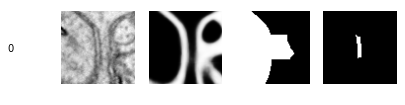

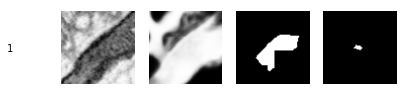

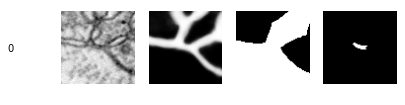

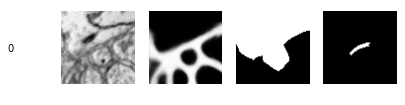

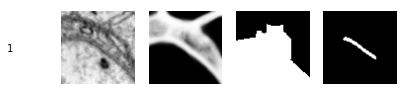

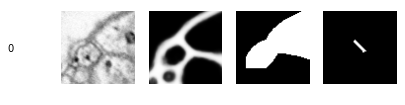

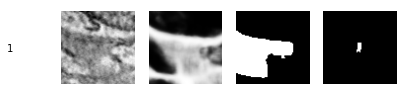

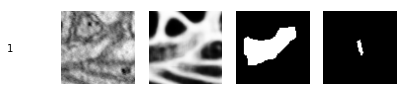

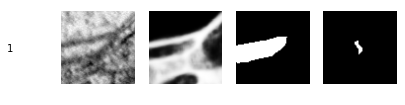

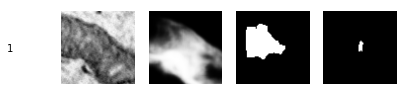

In [49]:
for key in range(10):
    mlpu.Util.view_rgba(X_train[key], text=y_train[key])